# Speech Enhancement

Speech enhancement is a fundamental task in speech processing applications. You barely receive clean signals in the wild - various types of noise can easily introduce distortion to the speech signal and harms both the perceptual quality and the accuracy of speech recognition systems. Although recent speech-related applications are typically designed or trained to be noise-robust, for human-oriented applications, e.g. hearing devices and telecommunication scenarios, explicit speech enhancement and denoising are still necessary and important.

There are many possible ways to perform speech enhancement. You may have heard about algorithms such as *subspace method*, *independent component analysis*, *dictionary learning*, *linear predictive coding*, etc., but we are not going to cover too much of the details about all of them. We will implement one of the most famous algorithms, the **Wiener filter**, as an example of the conventional methods. 

In recent years, the so-called **deep noise suppression** framework, where deep neural networks are designed and used for the speech enhancement task, is becoming more and more popular. Such models have already been successfully deployed into applications and devices that we use everyday, such as Siri, Google assistant, Cortana, Facetime, etc. Here we will also implement a **regression-based mapping** using neural networks. Most of the script is already prepared, and you need to implement the ones marked as **TODO**. 

We will only cover the single-channel enhancement framework here (you only have one observation). Multi-channel speech enhancement can be done by certain techniques for microphone array processing, and we may introduce some of them in the future.

In [1]:
import numpy as np
import librosa
import os
import time
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## 1. Data Preparation

After HW1, you should be familiar with the data preparation process. Here we will skip the details and directly start with the saved *h5py* file provided.

In [2]:
# load the training set
tr_dataset = h5py.File('enhancement-dataset/train', 'r')
val_dataset = h5py.File('enhancement-dataset/validation', 'r')
test_dataset = h5py.File('enhancement-dataset/test', 'r')

In [3]:
# listen to one example
from IPython.display import Audio

sample_idx = 15
sample_noisy_speech = test_dataset['noisy_speech'][sample_idx]
sample_speech = test_dataset['speech'][sample_idx]

In [4]:
# noisy speech
Audio(sample_noisy_speech, rate=16000)

In [5]:
# clean target
Audio(sample_speech, rate=16000)

# 2. Wiener Filter

Wiener filter is a very famous technique for speech enhancement and noise suppression. We will go through a most simple definition of Wiener filter in this section.

Wiener filter is a minimum-mean-square-error (MMSE) estimator of the signal-of-interest (SOI) given a noisy observation. It often requires that the signals are **stationary**, i.e. their statistics are time-invariant and do not change over time (such an assumption does not really hold for many real-world noise which are time-variant and nonstationary). In this case, the statistics of the noise can be estimated from certain noise-only regions (recall what we did for VAD in homework1), and the Wiener filter can be estimated from it.

Wiener filter is a time-invariant filter and we typically define it in the frequency domain. Suppose that we have a noisy signal $y(t) = x(t) + n(t)$ where $x(t)$ is the clean signal and $n(t)$ is the additive noise, we first calculate their STFT:

$Y(\omega, t) = X(\omega, t) + N(\omega, t)$

A Wiener filter is a time-invariant filter $M(\omega)$ multiplied to each frame in $Y(\omega, t)$ (remember that convolution in time domain is identical to multiplication in frequency domain), such that it minimizes the expectation of the MSE between the filtered signal $Y(\omega, t) \cdot M(\omega)$ and the target clean signal $X(\omega, t)$: $L = E[|Y(\omega, t) \cdot M(\omega) - X(\omega, t)|^2]$. This means that after applying the filter $M(\omega)$ to the noisy signal, the energy of the remaining noise $Y(\omega, t) \cdot M(\omega) - X(\omega, t)$ is minimized.

Note that function $L$ is a quadratic function of $M(\omega)$ with coefficient $|Y(\omega, t)|^2 \geqslant 0$, so we can calculate its gradient w.r.t $M(\omega)$ and set it to 0 to solve the optimal solution of $M(\omega)$:

$\frac{\partial L}{\partial M(\omega)} = 2(E[Y(\omega, t) \cdot M(\omega) - X(\omega, t))Y^H(\omega, t)] = 0$ => $E[|Y(\omega, t)|^2M(\omega)] = E[X(\omega, t)Y^H(\omega, t)]$

where H corresponds to the conjugate transpose of a complex-valued number. Generally we assume that (1) the noise $n(t)$ and the clean signal $x(t)$ are uncorrelated, and (2) the distribution of the noise is zero-mean. These two assumptions allow us to rewrite $E[X(\omega, t)Y^H(\omega, t)]$ as $E[X(\omega, t)(X^H(\omega, t) + N^H(\omega, t))] = E[|X(\omega, t)|^2 + X(\omega, t)N^H(\omega, t)] = E[|X(\omega, t)|^2]$ as $E[X(\omega, t)N^H(\omega, t)] = 0$.

Remember that $M(\omega)$ is a vector, $Y(\omega, t)$ and $X(\omega, t)$ are matrices, and $E[|X(\omega, t)|^2]$ and $E[|Y(\omega, t)|^2]$ are vectors due to the expectation (averaging) operation. Hence we have:

$M(\omega) = \frac{E[|X(\omega, t)|^2]}{E[|Y(\omega, t)|^2]}$

Reuse the fact that $E[X(\omega, t)N^H(\omega, t)] = 0$, we have:

$E[|Y(\omega, t)|^2] = E[|(X(\omega, t) + N(\omega, t)|^2] = E[|(X(\omega, t)|^2] + E[|N(\omega, t)|^2] + 2E[X(\omega, t)N^H(\omega, t)] = E[|(X(\omega, t)|^2] + E[|N(\omega, t)|^2]$

Hence $M(\omega) = \frac{E[|X(\omega, t)|^2]}{E[|Y(\omega, t)|^2]} = \frac{E[|Y(\omega, t)|^2] - E[|N(\omega, t)|^2]}{E[|Y(\omega, t)|^2]}$

This is the Wiener filter for noise suppression. We can easily find that $M(\omega)$ is real-valued, so it will not modify the phase spectrogram of $Y(\omega, t)$. The reconstruction of time-domain estimated signal can be done by inverse STFT.

To summarize the procedure of the calculation of a basic Wiener filter:

- Find the noise-only regions in the noisy signal (via VAD)

- Perform STFT on the signal

- Calculate the power spectrum of noisy signal, calculate the power spectrum of the noise signal using the noise-only regions

- Calculate the Wiener filter $M(\omega)$ using the two power spectrums

- Apply the filter to the noisy spectrogram and perform inverse STFT

Now let's implement it and test it on the sample we heard above. Here we simply assume that the noisy region is already known (the last second in the noisy signal), but in general you need a VAD to do the detection.

In [7]:
# Wiener filter

sr = 16000
noise_region = sample_noisy_speech[sr*3:]  # last second for noise signal

# STFT on both noisy signal and noise-only region
noisy_signal_spec = librosa.stft(sample_noisy_speech, n_fft=512, hop_length=128)  # shape (freq, frame)
noise_spec = librosa.stft(noise_region, n_fft=512, hop_length=128)  # shape (freq, frame)

# power spectrum
power_noisy_signal = np.mean(np.power(np.abs(noisy_signal_spec), 2), 1)  # average power across frames
power_noise = np.mean(np.power(np.abs(noise_spec), 2), 1)  # average power across frames

# Wiener filter calculation
wiener_filter = (power_noisy_signal - power_noise) / power_noisy_signal

# apply the filter to the noisy spectrogram

filtered_spec = noisy_signal_spec * wiener_filter.reshape(-1, 1)

# inverse STFT
enhanced_signal = librosa.istft(filtered_spec, win_length=512, hop_length=128)

In [8]:
# signal-to-noise ratio (SNR) of the residual noise after filtering in dB scale
post_snr = 10 * np.log10(np.sum(np.power(sample_speech, 2)) / np.sum(np.power(enhanced_signal - sample_speech, 2)))

# signal-to-noise ratio (SNR) of the original residual noise in dB scale
original_snr = 10 * np.log10(np.sum(np.power(sample_speech, 2)) / np.sum(np.power(sample_noisy_speech - sample_speech, 2)))

print('SNR before filtering: {:2f} dB, SNR after filtering: {:2f} dB'.format(original_snr, post_snr))

SNR before filtering: 4.032390 dB, SNR after filtering: 4.803914 dB


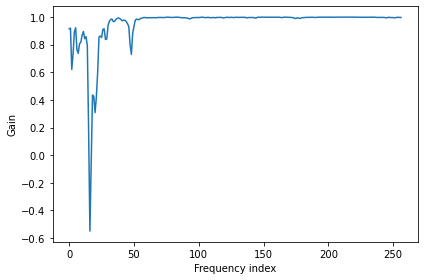

In [9]:
# plot the frequency response of the Wiener filter
plt.plot(np.arange(len(wiener_filter)), wiener_filter)
plt.xlabel('Frequency index')
plt.ylabel('Gain')
plt.tight_layout()

In [10]:
# listen to the output
Audio(enhanced_signal, rate=sr)

Listen to the results - you may find that the result is not really satisfying. Why?

The  main reason is that the noise is not really stationary. Next we try another type of noise - the sinusoid and do Wiener filtering again.

In [11]:
# sinusoid noise
sine_noise = np.sin(np.arange(len(sample_noisy_speech))) / 20
sine_signal = sine_noise + sample_speech

# listen to it
Audio(sine_signal, rate=sr)

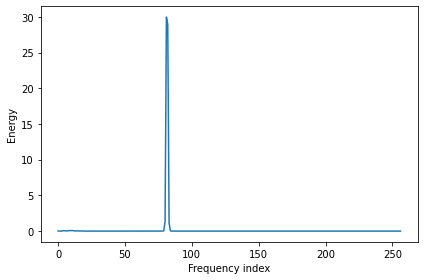

In [12]:
# plot the frequency response of the sinusoid noise
noise_spec = librosa.stft(sine_signal, n_fft=512, hop_length=128)  # shape (freq, frame)
plt.plot(np.arange(noise_spec.shape[0]), np.mean(np.power(np.abs(noise_spec), 2), 1))
plt.xlabel('Frequency index')
plt.ylabel('Energy')
plt.tight_layout()

In [13]:
# do Wiener filter again

noise_region = sine_signal[sr*3:]  # last second for noise signal

# STFT on both noisy signal and noise-only region
noisy_signal_spec = librosa.stft(sine_signal, n_fft=512, hop_length=128)  # shape (freq, frame)
noise_spec = librosa.stft(noise_region, n_fft=512, hop_length=128)  # shape (freq, frame)

# power spectrum
power_noisy_signal = np.mean(np.power(np.abs(noisy_signal_spec), 2), 1)  # average power across frames
power_noise = np.mean(np.power(np.abs(noise_spec), 2), 1)  # average power across frames

# Wiener filter calculation
wiener_filter = (power_noisy_signal - power_noise) / power_noisy_signal

# apply the filter to the noisy spectrogram

filtered_spec = noisy_signal_spec * wiener_filter.reshape(-1, 1)

# inverse STFT
enhanced_signal = librosa.istft(filtered_spec, win_length=512, hop_length=128)

In [14]:
# signal-to-noise ratio (SNR) of the residual noise after filtering in dB scale
post_snr = 10 * np.log10(np.sum(np.power(sample_speech, 2)) / np.sum(np.power(enhanced_signal - sample_speech, 2)))

# signal-to-noise ratio (SNR) of the original residual noise in dB scale
original_snr = 10 * np.log10(np.sum(np.power(sample_speech, 2)) / np.sum(np.power(sine_signal - sample_speech, 2)))

print('SNR before filtering: {:2f} dB, SNR after filtering: {:2f} dB'.format(original_snr, post_snr))

SNR before filtering: -19.030740 dB, SNR after filtering: 10.717996 dB


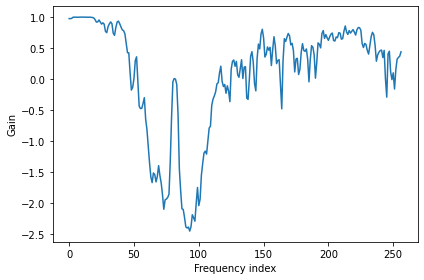

In [15]:
# plot the frequency response of the Wiener filter
plt.plot(np.arange(len(wiener_filter)), wiener_filter)
plt.xlabel('Frequency index')
plt.ylabel('Gain')
plt.tight_layout()

In [16]:
# listen to the output
Audio(enhanced_signal, rate=sr)

Now we have a significant performance improvement - SNR improved from -12.9 dB to 16.3 dB. Almost a 30 dB boost! The sinusoid noise is almost completely cancelled. That's why the stationary assumption is necessary for time-invariant Wiener filter - the characteristics of the noise should be stable across time for a good performance.

There are many ways to perform non-stationary Wiener filtering, and we will not cover them here.

## 2. Regression-based Mapping via Neural Network

We have already used neural networks to perform VAD in homework 1. Let's build another network for speech enhancement.

The dataset provided has been pre-processed so that all the utterances are 4-second long. Unlike the VAD task where we used a simple MLP for binary classification, here we use a recurrent neural network, the deep LSTM network we went through in homework 1, for this task.

A regression-based mapping for speech enhancement directly maps the noisy signal $y(t)$ to the target clean signal $x(t)$. We still operate in the frequency domain, and we will use a deep LSTM network to map the magnitude spectrogram $|Y(\omega, t)|$ to $|X(\omega, t)|$. Similar to the Wiener filter, we do not modify the phase spectrogram here, but there are actual ways to jointly modify magnitude and phase. Here we will only play with the magnitude spectrogram.

Let's define the data loader first.

In [17]:
from torch.utils.data import Dataset, DataLoader

batch_size = 8

# a class to load the saved h5py dataset
class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.noisy_speech = self.h5pyLoader['noisy_speech']
        self.speech = self.h5pyLoader['speech']
        
        self._len = self.noisy_speech.shape[0]  # number of utterances
    
    def __getitem__(self, index):
        # calculate STFT here
        noisy_speech_spec = librosa.stft(self.noisy_speech[index].astype(np.float32), n_fft=512, hop_length=128)
        speech_spec = librosa.stft(self.speech[index].astype(np.float32), n_fft=512, hop_length=128)
        noisy_speech_spec = torch.from_numpy(np.abs(noisy_speech_spec))  # only use the magnitude spectrogram
        speech_spec = torch.from_numpy(np.abs(speech_spec))
            
        return noisy_speech_spec, speech_spec
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline('enhancement-dataset/train'), 
                          batch_size=batch_size, 
                          shuffle=True,
                         )

validation_loader = DataLoader(dataset_pipeline('enhancement-dataset/validation'), 
                               batch_size=batch_size, 
                               shuffle=False,
                              )

dataset_len = len(train_loader)
log_step = dataset_len // 4

Note that the provided dataset has **not** been normalized. Although we can perform MVN at the dataset level, we can also perform MVN at utterance level, i.e. during the processing of each utterance.

Now implement a 2-layer LSTM network with 128 hidden units. Perform MVN before the first LSTM, and rescale the output back by applying the mean and standard deviation you calculated to the output (multiply with the standard deviation, and add the mean). Also, remenber that the magnitude spectrogram is always nonnegative, so you need to make sure your final output (rescaled output) is nonnegative. The [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function allows you to do so. 

You can reuse the network you implemented in homework 1.

In [99]:
# load the training set
tr_name='enhancement-dataset/train'
h5pyLoader = h5py.File(tr_name, 'r')
noisy_speech = h5pyLoader['noisy_speech']
for i in range(len(noisy_speech)):
    noisy_speech_spec = librosa.stft(noisy_speech[i].astype(np.float32), n_fft=512, hop_length=128)
    noisy_speech_spec = np.abs(noisy_speech_spec)  # only use the magnitude spectrogram
    if i==0:
        tr_d=noisy_speech_spec[np.newaxis,:,:]
    else:
        tr_d=np.concatenate((tr_d,noisy_speech_spec[np.newaxis,:,:]),axis=0)
tr_spec = np.transpose(tr_d[:], (0, 2, 1)).reshape(-1, np.shape(tr_d)[1])  # shape: (num_data*T, n_fft/2+1)
tr_mean = np.mean(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_var = np.var(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_std = np.sqrt(tr_var + 1e-8)  # again for numerical stability

In [100]:
print(np.shape(tr_mean.reshape(1,-1,1)))

(1, 257, 1)


In [131]:

# a 2-layer LSTM
class extractlastcell(nn.Module):
    
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]
    
class DeepLSTM(nn.Module):
    def __init__(self, feature_dim, meann, stdd):
        super(DeepLSTM, self).__init__()
        
        batch_size=1
        # layers, and activation function
        
        self.feature_dim = feature_dim
        self.hidden_unit = 128  # number of hidden units
        self.InitHidden=1
        self.mean=meann
        self.std=stdd
        # TODO: first LSTM layer
        
        self.layer1 = nn.LSTM(self.feature_dim, self.hidden_unit, num_layers=1, batch_first=True)

        # TODO: second LSTM layer
        self.layer2 = nn.LSTM(self.hidden_unit, self.hidden_unit, num_layers=1, batch_first=True)
        # output layer
        # this is an FC layer 
        self.output = nn.Sequential(nn.Linear(self.hidden_unit, self.feature_dim),
                                    nn.ReLU())
        
    # the function for the forward pass of network (i.e. from input to output)
    def forward(self, input):
        # the input is a batch of spectrograms with shape (batch_size, frequency_dim, time_step)
        
        
        batch_size, freq_dim, time_step = input.shape
        #mvn
        input=(input-self.mean.view(1,-1,1)) / self.std.view(1,-1,1)
    
       
        init_hidden1 = torch.zeros(1, batch_size,self.hidden_unit)  # initial hidden state is typically zero matrices
        init_cell1 = torch.zeros(1, batch_size,self.hidden_unit)  # now you also have a initial cell state
        init_hidden2 = torch.zeros(1, batch_size,self.hidden_unit)  # initial hidden state is typically zero matrices
        init_cell2 = torch.zeros(1, batch_size,self.hidden_unit)  # now you also have a initial cell state
        #self.InitHidden=0
        
        # note that LSTM layers require input with shape (batch_size, sequence_length, feature_dim)
        # so here we need to reshape the input
        
        input = input.transpose(1, 2).contiguous()  # (batch, time, freq), swap the two dimensions
        
        input.contiguous().view(batch_size*time_step, -1) #batch*time, freq
        
        # TODO: pass it through the 2 LSTM layers

        output, (output_hidden, output_cell) = self.layer1(input, (init_hidden1, init_cell1))  # process the input
       
        
        output, (output_hidden, output_cell) = self.layer2(output, (init_hidden2, init_cell2))  # process the input
        
        
        # the output should have shape (batch, time, hidden_unit)
        # pass to the output layer
        
        output = self.output(output.contiguous().view(batch_size*time_step, -1))  # (batch*time, freq)
        
        # reshape back
        output = output.view(batch_size, time_step, freq_dim)  # (batch, time, freq)
        output = output.transpose(1, 2).contiguous()  # (batch, freq, time), swap the two dimension back
        output= output*self.std.view(1,-1,1)+self.mean.view(1,-1,1)
        #mvn
        
        return output
    
model_LSTM = DeepLSTM(feature_dim=257, meann=torch.tensor(tr_mean),stdd=torch.tensor(tr_std))
optimizer = optim.Adam(model_LSTM.parameters(), lr=1e-3)

In [124]:
# MSE objective function for training

def MSE(input, output):
    # input shape: (batch, freq, time)
    # output shape: (batch, freq, time)
    
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    output = output.view(batch_size, -1)
    loss = (input - output).pow(2).sum(1)  # (batch_size, 1)
    return loss.mean()

In [125]:
# TODO: training and validation functions

# TODO: functions for training and validation
# Use BCE during training, and Accuracy during validation

def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        batch_nSpch = data[0]
        batch_Spch= data[1]
        
        # clean up the gradients in the optimizer
        # this should be called for each batch
        optimizer.zero_grad()
        
        output = model(batch_nSpch)
        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = MSE(output, batch_Spch)
        
        # automatically calculate the backward pass
        loss.sum().backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.sum().data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        batch_nSpch = data[0]
        batch_Spch= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output = model(batch_nSpch)
        
            # MSE as objective
            loss = MSE(output,batch_Spch )
        
            validation_loss += loss.data.item()
    
    validation_loss /= (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss

In [126]:
# TODO: hyperparameters and model training
# train the model you implemented

total_epoch = 100  # train the model for 100 epochs
model_save = 'best_model_LSTM.pt'  # path to save the best validation model

# main function

training_loss = []
validation_loss = []

for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_LSTM, epoch))
    validation_loss.append(validate(model_LSTM, epoch))
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.min(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_LSTM.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)


| epoch   1 |     9/   38 batches | ms/batch 434.73 | BCE 346.0377 |
| epoch   1 |    18/   38 batches | ms/batch 429.79 | BCE 337.4392 |
| epoch   1 |    27/   38 batches | ms/batch 430.14 | BCE 324.0079 |
| epoch   1 |    36/   38 batches | ms/batch 427.39 | BCE 312.9182 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.15s | BCE 309.8794 |
    | end of validation epoch   1 | time:  1.87s | accs 257.7407 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |     9/   38 batches | ms/batch 435.23 | BCE 257.6830 |
| epoch   2 |    18/   38 batches | ms/batch 421.50 | BCE 246.4582 |
| epoch   2 |    27/   38 batches | ms/batch 417.92 | BCE 237.5106 |
| epoch 

    | end of validation epoch  11 | time:  1.61s | accs 121.8639 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  12 |     9/   38 batches | ms/batch 404.04 | BCE 122.3148 |
| epoch  12 |    18/   38 batches | ms/batch 407.92 | BCE 120.4773 |
| epoch  12 |    27/   38 batches | ms/batch 405.69 | BCE 121.2787 |
| epoch  12 |    36/   38 batches | ms/batch 407.54 | BCE 119.7099 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  12 | time: 15.43s | BCE 119.8880 |
    | end of validation epoch  12 | time:  1.62s | accs 119.6140 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best vali

| epoch  22 |     9/   38 batches | ms/batch 412.46 | BCE 109.8634 |
| epoch  22 |    18/   38 batches | ms/batch 412.64 | BCE 105.5992 |
| epoch  22 |    27/   38 batches | ms/batch 412.91 | BCE 105.3235 |
| epoch  22 |    36/   38 batches | ms/batch 411.27 | BCE 106.2260 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  22 | time: 15.51s | BCE 106.2552 |
    | end of validation epoch  22 | time:  1.68s | accs 109.3013 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  23 |     9/   38 batches | ms/batch 408.99 | BCE 107.7941 |
| epoch  23 |    18/   38 batches | ms/batch 408.28 | BCE 103.8767 |
| epoch  23 |    27/   38 batches | ms/batch 408.45 | BCE 104.6272 |
| epoch 

    | end of validation epoch  32 | time:  1.62s | accs 104.8788 |
---------------------------------------------------------------------------------------------------
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  33 |     9/   38 batches | ms/batch 398.24 | BCE 100.2894 |
| epoch  33 |    18/   38 batches | ms/batch 401.17 | BCE 99.7660 |
| epoch  33 |    27/   38 batches | ms/batch 399.84 | BCE 99.6393 |
| epoch  33 |    36/   38 batches | ms/batch 399.78 | BCE 99.3923 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  33 | time: 15.11s | BCE 99.8935 |
    | end of validation epoch  33 | time:  1.60s | accs 104.5489 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
-------

| epoch  43 |    27/   38 batches | ms/batch 408.16 | BCE 94.2223 |
| epoch  43 |    36/   38 batches | ms/batch 408.92 | BCE 94.6293 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  43 | time: 15.46s | BCE 94.8945 |
    | end of validation epoch  43 | time:  1.68s | accs 101.5315 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  44 |     9/   38 batches | ms/batch 408.92 | BCE 98.9494 |
| epoch  44 |    18/   38 batches | ms/batch 408.97 | BCE 95.9616 |
| epoch  44 |    27/   38 batches | ms/batch 415.71 | BCE 95.3345 |
| epoch  44 |    36/   38 batches | ms/batch 415.61 | BCE 95.0393 |
------------------------------------------------------------------------------------

| epoch  54 |    27/   38 batches | ms/batch 398.62 | BCE 91.8004 |
| epoch  54 |    36/   38 batches | ms/batch 399.58 | BCE 92.2170 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  54 | time: 15.10s | BCE 92.0038 |
    | end of validation epoch  54 | time:  1.61s | accs 99.3479 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  55 |     9/   38 batches | ms/batch 396.45 | BCE 91.5791 |
| epoch  55 |    18/   38 batches | ms/batch 397.73 | BCE 91.4155 |
| epoch  55 |    27/   38 batches | ms/batch 396.98 | BCE 91.2812 |
| epoch  55 |    36/   38 batches | ms/batch 397.79 | BCE 91.8751 |
-------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
    | end of training epoch  65 | time: 15.63s | BCE 90.6417 |
    | end of validation epoch  65 | time:  1.62s | accs 98.3901 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  66 |     9/   38 batches | ms/batch 394.59 | BCE 89.3309 |
| epoch  66 |    18/   38 batches | ms/batch 394.29 | BCE 91.7223 |
| epoch  66 |    27/   38 batches | ms/batch 395.70 | BCE 91.0106 |
| epoch  66 |    36/   38 batches | ms/batch 396.89 | BCE 90.5703 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  66 | time: 14.99s | BCE 90.2602 |
    | end of validation epoch  66 | time:  1.62s | accs 98

| epoch  76 |    36/   38 batches | ms/batch 398.52 | BCE 89.0218 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  76 | time: 15.07s | BCE 88.7947 |
    | end of validation epoch  76 | time:  1.62s | accs 97.6917 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  77 |     9/   38 batches | ms/batch 397.44 | BCE 89.3814 |
| epoch  77 |    18/   38 batches | ms/batch 398.40 | BCE 89.0561 |
| epoch  77 |    27/   38 batches | ms/batch 398.86 | BCE 88.2595 |
| epoch  77 |    36/   38 batches | ms/batch 403.90 | BCE 88.4332 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  77 | time: 15.32s | BCE 88.6958 |
    | end of validation epoch  77 |

---------------------------------------------------------------------------------------------------
    | end of training epoch  87 | time: 15.48s | BCE 87.7700 |
    | end of validation epoch  87 | time:  1.84s | accs 96.5118 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  88 |     9/   38 batches | ms/batch 418.68 | BCE 88.0901 |
| epoch  88 |    18/   38 batches | ms/batch 415.48 | BCE 88.5821 |
| epoch  88 |    27/   38 batches | ms/batch 422.16 | BCE 88.3013 |
| epoch  88 |    36/   38 batches | ms/batch 423.41 | BCE 87.5150 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  88 | time: 15.99s | BCE 87.3634 |
    | end of validation epoch  88 | time:  1.65s | accs 96

| epoch  99 |     9/   38 batches | ms/batch 403.91 | BCE 87.0911 |
| epoch  99 |    18/   38 batches | ms/batch 405.24 | BCE 86.9296 |
| epoch  99 |    27/   38 batches | ms/batch 404.63 | BCE 86.9748 |
| epoch  99 |    36/   38 batches | ms/batch 405.91 | BCE 87.7076 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  99 | time: 15.36s | BCE 87.6397 |
    | end of validation epoch  99 | time:  1.69s | accs 96.2418 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch 100 |     9/   38 batches | ms/batch 408.00 | BCE 85.5324 |
| epoch 100 |    18/   38 batches | ms/batch 409.58 | BCE 85.8238 |
| epoch 100 |    27/   38 batches | ms/batch 411.03 | BCE 86.4092 |
| epoch 100 |    36/   38 batches | ms/batch 412.36 | BCE 86.7408 |
---------------------------

After training, we can evaluate our model on the test set. Take an example utterance from the test set, extract its magnitude spectrogram, enhance it, reconstruct it back to the waveforms by inverse STFT with the unmodified phase spectrogram, and listen to it.

In [127]:
sample_noisy_speech = test_dataset['noisy_speech'][sample_idx]

# TODO: evaluate your model on this sample from the test set


noisy_speech_spec = librosa.stft(sample_noisy_speech.astype(np.float32), n_fft=512, hop_length=128)
noisy_speech_spec = np.abs(noisy_speech_spec)  # only use the magnitude spectrogram
noisy_speech_spec=noisy_speech_spec[np.newaxis,:,:]
print(np.shape(noisy_speech_spec))
model_LSTM.load_state_dict(torch.load('best_model_LSTM.pt'))

output_sample=model_LSTM(torch.tensor(noisy_speech_spec))
output_sample=np.squeeze(output_sample.cpu().detach().numpy())

enhanced_signal = librosa.istft(output_sample, win_length=512, hop_length=128)
# remember to load the best model found on validation set

(1, 257, 501)


In [128]:
# TODO: listen to both the noisy signal and your enhanced output
print('after:')
Audio(enhanced_signal, rate=sr)

after:


In [129]:
print('before:')
Audio(sample_noisy_speech, rate=sr)

before:


Compare the perceptual quality of the output from the Wiener filter and the deep LSTM. Which one sounds better? What are the remaining problems (e.g. distortion, SNR)?

In [ ]:
# TODO: enter your comments here
'''
the perceptual sound of Wiener filter is better for this level of training the reason for that is that here there are two things that are being done.
the network needs to understand how to find speech, and amplifies it and seperates it from noise. 
But in Wiener filter we already know the characterestics of noise. with lstm we have more distortion because
network needs to learn the spectral properties of speech and noise.
'''
